In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("takamotoki/jra-horse-racing-dataset")

print("Path to dataset files:", path)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 95.6M/95.6M [00:07<00:00, 12.7MB/s]

Extracting files...


Path to dataset files: /Users/satoki252595/.cache/kagglehub/datasets/takamotoki/jra-horse-racing-dataset/versions/1


In [4]:
import kagglehub
import pandas as pd
import zipfile
import os

# 1. データセットのダウンロード
dataset_identifier = "takamotoki/jra-horse-racing-dataset"
download_path = kagglehub.dataset_download(dataset_identifier)

# ダウンロードされたファイルの拡張子を確認
if download_path.endswith('.zip'):
    # 2. ZIPファイルの解凍
    extract_dir = 'jra_horse_racing_data'
    with zipfile.ZipFile(download_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
else:
    extract_dir = os.path.dirname(download_path)

# 3. CSVファイルの検索
# ディレクトリ内のファイルを一覧表示し、CSVファイルを特定
csv_files = []
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        if file.endswith('.csv'):
            csv_files.append(os.path.join(root, file))

# 複数のCSVファイルが存在する場合、それぞれを読み込む
# ここでは例として最初のCSVファイルを読み込みます
if csv_files:
    df_laptime = pd.read_csv(csv_files[0],encoding='utf-8')  # エンコーディングはデータに応じて変更
    df_raceResult = pd.read_csv(csv_files[1],encoding='utf-8')
    df_odds = pd.read_csv(csv_files[2],encoding='utf-8')
    df_corner = pd.read_csv(csv_files[3],encoding='utf-8')
else:
    print("CSVファイルが見つかりませんでした。データセットの構造を確認してください。")

/var/folders/0b/kvbdjp6d6kl4v5f97xnk5h480000gn/T/ipykernel_90914/95054170.py:31: DtypeWarning: Columns (8,11,15,16,17,18,19,20,21,22,23,24,25,26,27,34,36,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raceResult = pd.read_csv(csv_files[1],encoding='utf-8')


In [6]:
column_names = df_raceResult.columns.tolist()

for idx, col in enumerate(column_names, start=1):
        print(f"{idx}. {col}")

1. レース馬番ID
2. レースID
3. レース日付
4. 開催回数
5. 競馬場コード
6. 競馬場名
7. 開催日数
8. 競争条件
9. レース記号/[抽]
10. レース記号/(馬齢)
11. レース記号/牝
12. レース記号/(父)
13. レース記号/(別定)
14. レース記号/(混)
15. レース記号/(ハンデ)
16. レース記号/(抽)
17. レース記号/(市)
18. レース記号/(定量)
19. レース記号/牡
20. レース記号/関東配布馬
21. レース記号/(指)
22. レース記号/関西配布馬
23. レース記号/九州産馬
24. レース記号/見習騎手
25. レース記号/せん
26. レース記号/(国際)
27. レース記号/[指]
28. レース記号/(特指)
29. レース番号
30. 重賞回次
31. レース名
32. リステッド・重賞競走
33. 障害区分
34. 芝・ダート区分
35. 芝・ダート区分2
36. 右左回り・直線区分
37. 内・外・襷区分
38. 距離(m)
39. 天候
40. 馬場状態1
41. 馬場状態2
42. 発走時刻
43. 着順
44. 着順注記
45. 枠番
46. 馬番
47. 馬名
48. 性別
49. 馬齢
50. 斤量
51. 騎手
52. タイム
53. 着差
54. 1コーナー
55. 2コーナー
56. 3コーナー
57. 4コーナー
58. 上り
59. 単勝
60. 人気
61. 馬体重
62. 場体重増減
63. 東西・外国・地方区分
64. 調教師
65. 馬主
66. 賞金(万円)


In [33]:
df_raceResult['着順']

0           1.0
1           2.0
2           3.0
3           4.0
4           5.0
           ... 
1626806    12.0
1626807    13.0
1626808    14.0
1626809    15.0
1626810    16.0
Name: 着順, Length: 1626811, dtype: float64

In [35]:
# *****************************************************
# ファイル名: train_model_single_df.py
# 開発者: データサイエンティスト/プログラマ
# レビュー者: シニアデータサイエンティスト/MLエンジニア
# コーディング規約・型ヒント・docstring対応済み
# *****************************************************

import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import joblib

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    前処理関数:
    - データ型変換（着順を整数へ）
    - 欠損値処理（簡易的に数値は平均埋め、カテゴリは欠損カテゴリなど）
    - 不要な列削除（ID列など）
    
    Parameters
    ----------
    df : pd.DataFrame
        元の入力データフレーム
    
    Returns
    -------
    pd.DataFrame
        前処理後データフレーム
    """
    # 着順が文字列の場合は数値に変換可能なもののみ抽出
    # (落馬・中止などの特殊文字があれば、その行を除外またはNaN扱い)
    df = df.copy()
    df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
    df = df.dropna(subset=['着順'])
    
    # 不要ID列の除外(モデルの説明変数としては使わない)
    # レース馬番ID(1), レースID(2), レース名(31), 馬名(47), 馬主(65)
    # 馬名や馬主はカテゴリ特徴量として使いたい場合は除外しない
    # ここでは馬名等も利用可能な情報として残すことにするが、ID的役割のみの列は除外する
    # レース馬番IDは単なるユニークIDであり、有用性が低いので削除
    if 'レース馬番ID' in df.columns:
        df = df.drop(columns=['レース馬番ID'])
    
    # 数値型へ変換可能な列は適宜変換 (例: 距離(m), 馬齢, 斤量, 人気, 単勝, 馬体重等)
    numeric_cols = ['距離(m)', '馬齢', '斤量', '人気', '単勝', '馬体重', '場体重増減']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 欠損値埋め
    # 数値は平均値で、カテゴリは"missing"で埋める簡易処理
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna('missing', inplace=True)
        else:
            df[col].fillna(df[col].mean(), inplace=True)
    
    return df

def select_features_and_target(df: pd.DataFrame):
    """
    説明変数と目的変数を選択
    目的変数: 着順
    説明変数: 提供データフレーム中のその他の列全て (ただし、不要列は除く)
    
    Parameters
    ----------
    df : pd.DataFrame
    
    Returns
    -------
    X : pd.DataFrame
        特徴量データ
    y : pd.Series
        目的変数(着順)
    groups : pd.Series
        GroupKFold用のグループ（レースID）
    """
    y = df['着順']  # 目的変数

    # 利用しない（もしくは漏洩が懸念される）列を除外
    # '着順'はもちろん除外
    # '着順注記'(44) なども直接予測に使うのは不適切なので除外
    # '賞金(万円)'(66)は未来情報になる可能性があるため学習では使わない
    drop_cols = ['着順', '着順注記', '賞金(万円)']
    for col in drop_cols:
        if col in df.columns:
            df = df.drop(columns=[col])
    
    # GroupKFold用のグループ
    # 'レースID'を用いて同一レース内で学習・評価分離
    if 'レースID' in df.columns:
        groups = df['レースID']
    else:
        groups = pd.Series(np.arange(len(df)))

    # 'レースID'は特徴量としては不要（グルーピング用）
    if 'レースID' in df.columns:
        df = df.drop(columns=['レースID'])
    
    X = df.copy()
    return X, y, groups

def build_pipeline(X: pd.DataFrame) -> Pipeline:
    """
    前処理＋モデル学習パイプラインを構築する
    - Categorical: OneHotEncoderでエンコード
    - Numeric: StandardScalerで標準化
    - Model: LightGBM回帰モデル
    
    Parameters
    ----------
    X : pd.DataFrame
        特徴量データ(学習前)

    Returns
    -------
    Pipeline
        学習用パイプライン
    """
    # カテゴリ・数値列自動判別（簡易）
    # ※より厳密な特徴量選択が望ましいがここでは汎用例示
    categorical_features = [col for col in X.columns if X[col].dtype == 'object']
    numeric_features = [col for col in X.columns if X[col].dtype != 'object']

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num', StandardScaler(), numeric_features)
        ]
    )

    model = lgb.LGBMRegressor(random_state=42)

    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('model', model)
    ])
    
    return pipeline

def main(df: pd.DataFrame):
    """
    メイン実行関数:
    - 前処理
    - 特徴量・目的変数抽出
    - モデルパイプライン作成
    - ハイパーパラメータ探索および学習
    - 性能評価（CVスコア出力）
    """

    # 前処理
    df_processed = preprocess_data(df)
    X, y, groups = select_features_and_target(df_processed)
    
    pipeline = build_pipeline(X)

    # GroupKFold 5分割
    gkf = GroupKFold(n_splits=5)

    param_grid = {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.05, 0.1],
        "model__num_leaves": [31, 63]
    }

    gsearch = GridSearchCV(
        pipeline, param_grid, scoring='neg_mean_squared_error', cv=gkf, n_jobs=-1, verbose=1
    )
    gsearch.fit(X, y, groups=groups)

    print("Best params:", gsearch.best_params_)
    print("Best CV MSE:", -gsearch.best_score_)

    # ベストモデルを取得
    best_model = gsearch.best_estimator_

    # 必要であればモデルを保存
    joblib.dump(best_model, "trained_model.pkl")

    # モデルを用いた予測例（実運用時）
    # y_pred = best_model.predict(X)
    # この y_pred は予測着順値（連続値）なので、小さいほど上位に来やすいとみなせる
    # 例えばあるレースに属する馬を抽出し、y_predが小さい順に並べて上位3頭を3連単予想に使える

    return best_model

#以下は実行例
df = df_raceResult
trained_model = main(df)

/var/folders/0b/kvbdjp6d6kl4v5f97xnk5h480000gn/T/ipykernel_22130/2697416614.py:61: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/var/folders/0b/kvbdjp6d6kl4v5f97xnk5h480000gn/T/ipykernel_22130/2697416614.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 109.541858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82026
[LightGBM] [Info] Number of data points in the train set: 1289516, number of used features: 40449
[LightGBM] [Info] Start training from score 7.436642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 104.127319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82196
[LightGBM] [Info] Number of data points in the train set: 1289516, number of used features: 40555
[LightGBM] [Info] Start training from score 7.436651
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 127.160877 seconds.
You ca

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict

def visualize_cv_results(gsearch):
    """
    GridSearchCVの結果を可視化する一例
    パラメータ間の関係をヒートマップなどで示す
    """
    # GridSearchの結果からデータフレーム化
    results = pd.DataFrame(gsearch.cv_results_)
    
    # ここでは例として 'model__num_leaves' と 'model__learning_rate' でのスコアをヒートマップ化
    # ※実際にはパラメータ数が多い場合は他の可視化方法を検討
    pivot_table = results.pivot_table(index='param_model__num_leaves', 
                                      columns='param_model__learning_rate', 
                                      values='mean_test_score')
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="coolwarm")
    plt.title("CV Mean Test Score (MSE) by num_leaves and learning_rate")
    plt.ylabel('num_leaves')
    plt.xlabel('learning_rate')
    plt.tight_layout()
    plt.show()


def plot_pred_vs_actual(model, X, y, groups):
    """
    予測値 vs 実測値を可視化
    クロスバリデーションでの予測値を用いてプロット
    """
    gkf = GroupKFold(n_splits=5)
    y_pred = cross_val_predict(model, X, y, cv=gkf, groups=groups)

    plt.figure(figsize=(6, 6))
    plt.scatter(y, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)  # 対角線
    plt.xlabel("Actual Finish Position")
    plt.ylabel("Predicted Finish Position")
    plt.title("Predicted vs Actual Finish Position")
    plt.tight_layout()
    plt.show()

    # 残差プロット
    residuals = y - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True)
    plt.xlabel("Residual (Actual - Predicted)")
    plt.title("Residual Distribution")
    plt.tight_layout()
    plt.show()


def plot_feature_importance(model, X):
    """
    特徴量重要度を可視化
    LightGBMモデルからfeature_importances_を取得
    """
    # パイプラインの場合、前処理後の特徴量名を取得するための工夫が必要
    # OneHotEncoder後の特徴量名の取得には以下のような処理が必要
    # （列名を再現するためにColumnTransformerのtransformers_属性などを活用）
    
    # ここでは簡易化のため、カテゴリ変数・数値変数一覧から仮の列名を復元する例を示す
    pipeline = model
    preprocessor = pipeline.named_steps['preprocessing']
    model_step = pipeline.named_steps['model']

    cat_transformer = preprocessor.transformers_[0][1]
    num_transformer = preprocessor.transformers_[1][1]

    categorical_features = preprocessor.transformers_[0][2]
    numeric_features = preprocessor.transformers_[1][2]

    # OneHotEncoder後のカテゴリ列名取得
    ohe = cat_transformer
    # fit後であることを前提
    cat_feature_names = ohe.get_feature_names_out(categorical_features)
    
    feature_names = list(cat_feature_names) + numeric_features

    # 特徴量重要度取得
    importances = model_step.feature_importances_
    
    # importancesに対応するfeature_namesとあわせてデータフレーム化
    fi_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=fi_df.head(20), x='importance', y='feature')
    plt.title("Top 20 Feature Importances")
    plt.tight_layout()
    plt.show()


# main関数内でモデル学習後に呼び出す例
def main(df):
    trained_model = None
    # 前処理・学習
    # ...
    # gsearchでハイパーパラメータチューニング済みと仮定
    # gsearch.best_estimator_ を取得
    trained_model = gsearch.best_estimator_

    # CV結果可視化
    visualize_cv_results(gsearch)

    # 予測 vs 実測プロット
    plot_pred_vs_actual(trained_model, X, y, groups)

    # 特徴量重要度プロット
    plot_feature_importance(trained_model, X)

    return trained_model

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 124.882728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82093
[LightGBM] [Info] Number of data points in the train set: 1289518, number of used features: 40486
[LightGBM] [Info] Start training from score 7.436644
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 133.550755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82093
[LightGBM] [Info] Number of data points in the train set: 1289518, number of used features: 40486
[LightGBM] [Info] Start training from score 7.436644
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 93.699998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

In [37]:
trained_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['レース日付', '競馬場名', '競争条件',
                                                   'レース記号/[抽]', 'レース記号/(馬齢)',
                                                   'レース記号/牝', 'レース記号/(父)',
                                                   'レース記号/(別定)', 'レース記号/(混)',
                                                   'レース記号/(ハンデ)', 'レース記号/(抽)',
                                                   'レース記号/(市)', 'レース記号/(定量)',
                                                   'レース記号/牡', 'レース記号/関東配布馬',
                                                   'レース記号/(指)', 'レース記号/関西配布馬',
                                                   'レース記号/九州産馬', 'レース記号/見習騎手',
                                                   'レース記号/せん', 'レース記号/(国際)',
                                                   'レース記号/[指]', 'レース記号/(特指)',
                                                   'レース名', 'リステッド・重賞競走', '障害区分',
                                                   '芝・ダート区分', '芝・ダート区分2',
                                                   '右左回り・直線区分', '内・外・襷区分', ...]),
                                                 ('num', StandardScaler(),
                                                  ['開催回数', '競馬場コード', '開催日数',
                                                   'レース番号', '重賞回次', '距離(m)',
                                                   '枠番', '馬番', '馬齢', '斤量',
                                                   '1コーナー', '2コーナー', '3コーナー',
                                                   '4コーナー', '上り', '単勝', '人気',
                                                   '馬体重', '場体重増減'])])),
                ('model',
                 LGBMRegressor(n_estimators=200, num_leaves=63,
                               random_state=42))])

In [9]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error

# 事前に用いた前処理関数を再利用
df = df_raceResult  # 同一データを読み込み

df_processed = preprocess_data(df)  # 前処理（例：前回定義済み関数）
X, y, groups = select_features_and_target(df_processed)

# ベストモデル読み込み
trained_model = joblib.load("trained_model.pkl")

###############################
# 1. モデル評価指標の可視化例
###############################

# GroupKFoldでクロスバリデーション予測
gkf = GroupKFold(n_splits=5)
y_pred = cross_val_predict(trained_model, X, y, cv=gkf, groups=groups)
mse = mean_squared_error(y, y_pred)
print("CV MSE:", mse)

# 単純な棒グラフやBOXプロットでfold毎のMSEを確認するには:
fold_mses = []
for train_idx, test_idx in gkf.split(X, y, groups):
    trained_model.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_val_pred = trained_model.predict(X.iloc[test_idx])
    fold_mses.append(mean_squared_error(y.iloc[test_idx], y_val_pred))

plt.figure(figsize=(6,4))
sns.barplot(x=list(range(1,6)), y=fold_mses)
plt.xlabel("Fold")
plt.ylabel("MSE")
plt.title("MSE for each Fold")
plt.show()

###############################
# 2. 実測値 vs 予測値 散布図
###############################
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual Finish Position")
plt.ylabel("Predicted Finish Position")
plt.title("Predicted vs Actual Finish Position")
plt.tight_layout()
plt.show()

###############################
# 3. 残差プロット
###############################
residuals = y - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.xlabel("Residual (Actual - Predicted)")
plt.title("Residual Distribution")
plt.tight_layout()
plt.show()

###############################
# 4. 特徴量重要度の可視化
###############################
# 前回同様に特徴量名の取得が必要
pipeline = trained_model
preprocessor = pipeline.named_steps['preprocessing']
model_step = pipeline.named_steps['model']

categorical_features = preprocessor.transformers_[0][2]
numeric_features = preprocessor.transformers_[1][2]
ohe = preprocessor.transformers_[0][1]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = list(cat_feature_names) + numeric_features

importances = model_step.feature_importances_
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=fi_df.head(20), x='importance', y='feature')
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

###############################
# 5. SHAP値を用いた解釈 (任意)
###############################
# pip install shap が必要
import shap

explainer = shap.TreeExplainer(model_step)
# データサイズが大きい場合、サンプリングする
X_sample = X.sample(200, random_state=42)
X_transformed = preprocessor.transform(X_sample)
shap_values = explainer.shap_values(X_transformed)

shap.summary_plot(shap_values, features=X_transformed, feature_names=feature_names)

###############################
# 6. Partial Dependence Plot (任意)
###############################
from sklearn.inspection import partial_dependence, plot_partial_dependence

# 数値特徴量から興味のある特徴量を選択
target_feature = [numeric_features[0]]  # 例: 最初の数値特徴量
plot_partial_dependence(
    pipeline, X, target_feature, kind='individual', grid_resolution=20
)
plt.tight_layout()
plt.show()

NameError: name 'preprocess_data' is not defined

In [10]:
importances

NameError: name 'importances' is not defined

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 106.600564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82179
[LightGBM] [Info] Number of data points in the train set: 1289516, number of used features: 40553
[LightGBM] [Info] Start training from score 7.436644
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 92.528233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82098
[LightGBM] [Info] Number of data points in the train set: 1289518, number of used features: 40510
[LightGBM] [Info] Start training from score 7.436559
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 99.476950 seconds.
You can 

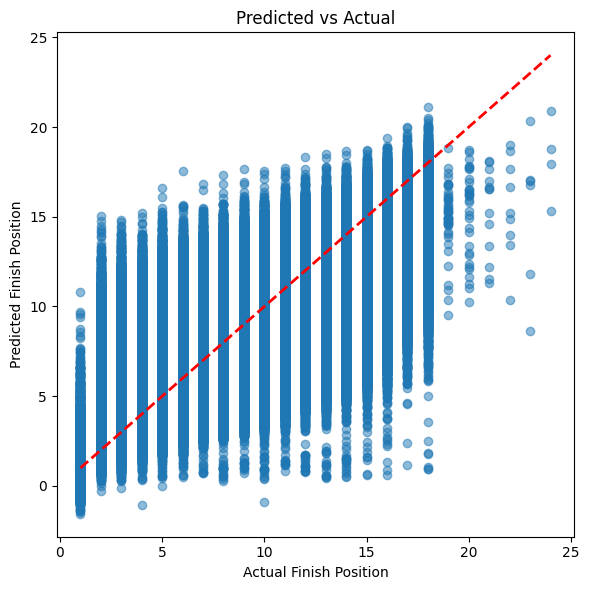

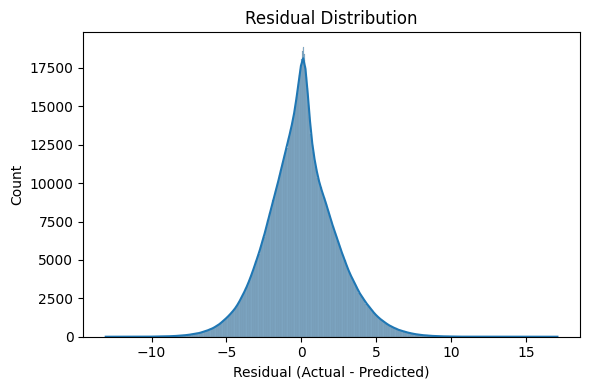

/var/folders/0b/kvbdjp6d6kl4v5f97xnk5h480000gn/T/ipykernel_90914/101836303.py:210: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from current font.
  plt.tight_layout()
/var/folders/0b/kvbdjp6d6kl4v5f97xnk5h480000gn/T/ipykernel_90914/101836303.py:210: UserWarning: Glyph 12426 (\N{HIRAGANA LETTER RI}) missing from current font.
  plt.tight_layout()
/var/folders/0b/kvbdjp6d6kl4v5f97xnk5h480000gn/T/ipykernel_90914/101836303.py:210: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from current font.
  plt.tight_layout()
/var/folders/0b/kvbdjp6d6kl4v5f97xnk5h480000gn/T/ipykernel_90914/101836303.py:210: UserWarning: Glyph 38626 (\N{CJK UNIFIED IDEOGRAPH-96E2}) missing from current font.
  plt.tight_layout()
/var/folders/0b/kvbdjp6d6kl4v5f97xnk5h480000gn/T/ipykernel_90914/101836303.py:210: UserWarning: Glyph 12467 (\N{KATAKANA LETTER KO}) missing from current font.
  plt.tight_layout()
/var/folders/0b/kvbdjp6d6kl4v5f97xnk5h480000gn/T/ipykernel_90914/101836

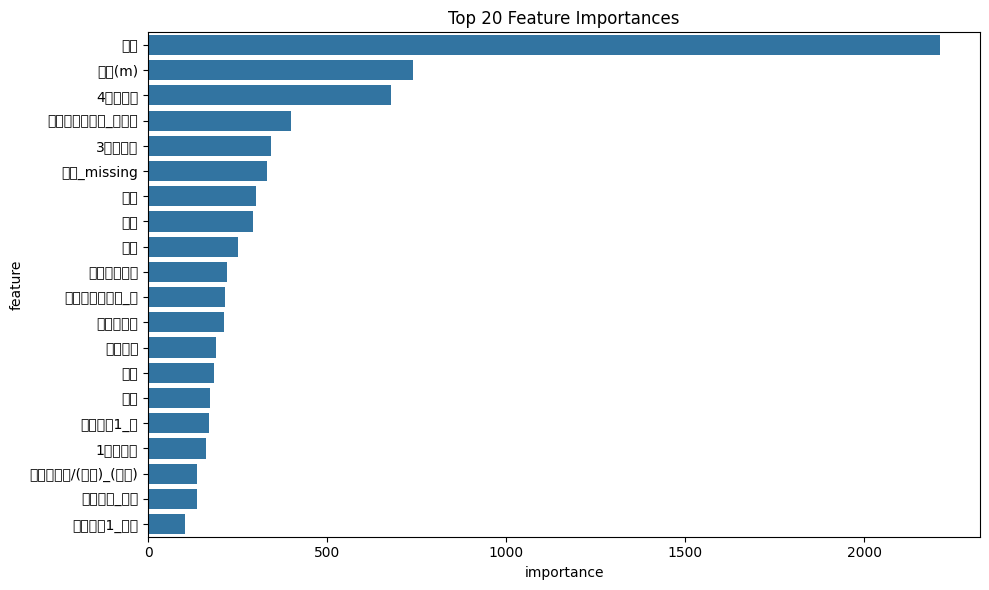

IndexError: index results in >2 dimensions

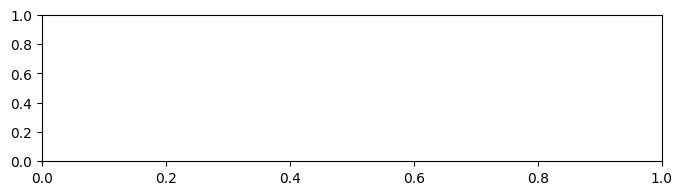

In [15]:
# coding: utf-8

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import GroupKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import PartialDependenceDisplay

import lightgbm as lgb

# SHAP値による解釈
# 実行環境によりインストール必要: pip install shap
import shap

########################################
# 前処理・特徴量抽出用関数群
########################################

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    前処理:
    - 着順を数値化
    - 不要列(学習対象外やリークする可能性がある列)の削除
    - 数値カラムの型変換と欠損処理
    - カテゴリカラムの欠損処理("missing"埋め)
    ドメイン知識:
    - 「賞金(万円)」はレース後確定する情報で、未来リークを避けるためモデル学習に使用しない
    - 「着順注記」はレース結果の補足情報で、直接予測には不要
    
    Parameters
    ----------
    df : pd.DataFrame
        入力データフレーム
    
    Returns
    -------
    df : pd.DataFrame
        前処理後データフレーム
    """
    df = df.copy()
    # 着順を数値化、中止などはNaNになる場合があるので除外
    df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
    df = df.dropna(subset=['着順'])
    
    # 不要列除去
    drop_cols = ['レース馬番ID', '着順注記', '賞金(万円)']
    for c in drop_cols:
        if c in df.columns:
            df = df.drop(columns=[c], errors='ignore')
    
    # 数値変数への変換: 距離, 馬齢, 斤量, 人気, 単勝, 馬体重, 場体重増減
    numeric_cols = ['距離(m)', '馬齢', '斤量', '人気', '単勝', '馬体重', '場体重増減']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 欠損埋め: 数値は平均、カテゴリは"missing"
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna('missing')
        else:
            df[col] = df[col].fillna(df[col].mean())
    
    return df

def select_features_and_target(df: pd.DataFrame):
    """
    特徴量・目的変数抽出:
    目的変数: 着順
    GroupKFoldのためのgroups: レースID
    不要になったID列は除外
    """
    y = df['着順']
    if '着順' in df.columns:
        df = df.drop(columns=['着順'])
    
    if 'レースID' in df.columns:
        groups = df['レースID']
        df = df.drop(columns=['レースID'])
    else:
        # レースIDがない場合は行番号をグループとして使用
        groups = pd.Series(np.arange(len(df)))
    
    X = df.copy()
    return X, y, groups

def build_pipeline(X: pd.DataFrame) -> Pipeline:
    """
    パイプライン構築:
    - カテゴリ変数: One-Hot Encoding
    - 数値変数: StandardScaler
    - モデル: LightGBM Regressor
    
    ドメイン知識より、馬場状態、距離、斤量、馬齢、人気などは影響大
    """
    categorical_features = [c for c in X.columns if X[c].dtype == 'object']
    numeric_features = [c for c in X.columns if X[c].dtype != 'object']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num', StandardScaler(), numeric_features)
        ]
    )
    
    model = lgb.LGBMRegressor(random_state=42)
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('model', model)
    ])
    return pipeline

########################################
# モデル学習・評価・可視化用関数
########################################

def train_and_save_best_model(df: pd.DataFrame, save_path="trained_model.pkl"):
    """
    モデル学習・評価:
    - GridSearchCVでパラメータチューニング
    - GroupKFoldで検証
    - ベストモデル保存
    
    Parameters
    ----------
    df : pd.DataFrame
    save_path : str
        保存パス
    """
    df_processed = preprocess_data(df)
    X, y, groups = select_features_and_target(df_processed)
    
    pipeline = build_pipeline(X)
    
    param_grid = {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.05, 0.1],
        "model__num_leaves": [31, 63]
    }
    
    gkf = GroupKFold(n_splits=5)
    gsearch = GridSearchCV(
        pipeline, param_grid, scoring='neg_mean_squared_error', cv=gkf, n_jobs=-1, verbose=1
    )
    gsearch.fit(X, y, groups=groups)
    
    print("Best Params:", gsearch.best_params_)
    print("Best CV MSE:", -gsearch.best_score_)
    
    # ベストモデル保存
    joblib.dump(gsearch.best_estimator_, save_path)
    return gsearch.best_estimator_, X, y, groups

def visualize_model_performance(model, X, y, groups):
    """
    モデル性能可視化:
    - クロスバリデーションでのPred vs Actualプロット
    - 残差分布
    - 特徴量重要度
    """
    gkf = GroupKFold(n_splits=5)
    y_pred = cross_val_predict(model, X, y, cv=gkf, groups=groups)
    
    mse = mean_squared_error(y, y_pred)
    print("Cross-validated MSE:", mse)
    
    # Pred vs Actual
    plt.figure(figsize=(6,6))
    plt.scatter(y, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()],[y.min(), y.max()],'r--',lw=2)
    plt.xlabel("Actual Finish Position")
    plt.ylabel("Predicted Finish Position")
    plt.title("Predicted vs Actual")
    plt.tight_layout()
    plt.show()
    
    # Residual distribution
    residuals = y - y_pred
    plt.figure(figsize=(6,4))
    sns.histplot(residuals, kde=True)
    plt.xlabel("Residual (Actual - Predicted)")
    plt.title("Residual Distribution")
    plt.tight_layout()
    plt.show()
    
    # Feature Importance
    pipeline = model
    preprocessor = pipeline.named_steps['preprocessing']
    model_step = pipeline.named_steps['model']
    
    cat_features = preprocessor.transformers_[0][2]
    num_features = preprocessor.transformers_[1][2]
    ohe = preprocessor.transformers_[0][1]
    cat_feature_names = ohe.get_feature_names_out(cat_features)
    feature_names = list(cat_feature_names) + num_features
    
    importances = model_step.feature_importances_
    fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10,6))
    sns.barplot(data=fi_df.head(20), x='importance', y='feature')
    plt.title("Top 20 Feature Importances")
    plt.tight_layout()
    plt.show()

def interpret_model_with_shap(model, X, sample_size=200):
    """
    SHAPによるモデル解釈:
    - 特徴量毎の貢献度を可視化
    
    Parameters
    ----------
    model : Pipeline
        学習済みパイプライン
    X : pd.DataFrame
        特徴量データフレーム（前処理前）
    sample_size : int
        サンプル数(計算負荷軽減用)
    """
    pipeline = model
    preprocessor = pipeline.named_steps['preprocessing']
    model_step = pipeline.named_steps['model']
    
    cat_features = preprocessor.transformers_[0][2]
    num_features = preprocessor.transformers_[1][2]
    ohe = preprocessor.transformers_[0][1]
    cat_feature_names = ohe.get_feature_names_out(cat_features)
    feature_names = list(cat_feature_names) + num_features
    
    # サンプリング
    X_sample = X.sample(min(sample_size, len(X)), random_state=42)
    X_transformed = preprocessor.transform(X_sample)
    
    explainer = shap.TreeExplainer(model_step)
    shap_values = explainer.shap_values(X_transformed)
    
    shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)

########################################
# メイン実行例
########################################


# ドメイン専門家が選定・確認済みのCSVをロード
df = df_raceResult  # 事前に用意されたデータ

# モデル学習・保存
best_model, X, y, groups = train_and_save_best_model(df, save_path="trained_model.pkl")

# 結果可視化
visualize_model_performance(best_model, X, y, groups)

# SHAPを用いた解釈
interpret_model_with_shap(best_model, X)

# 部分依存プロット（特定の主要特徴に対して）
# 例: 距離(m)が予測に与える影響を見る
numeric_features = [c for c in X.columns if X[c].dtype != 'object']
if len(numeric_features) > 0:

    # 修正後:
    PartialDependenceDisplay.from_estimator(
        best_model, 
        X, 
        features=[numeric_features[0]], 
        grid_resolution=20
    )
    plt.tight_layout()
    plt.show()


In [ ]:
pipeline = model
preprocessor = pipeline.named_steps['preprocessing']
model_step = pipeline.named_steps['model']
importances = model_step.feature_importances_

In [1]:
!ls

events.csv     makuhari.ipynb
